# I. Import initiaux

In [1]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tqdm

2025-09-30 11:26:40.763348: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-30 11:26:40.984375: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759224401.062128    1313 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759224401.082657    1313 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759224401.240515    1313 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Data exploration

On a deux folder:
    Un folder avec les photos séparés  séparés en 3 folders train test et val eux même séparés par villes
    Un folder avec les mask sous 4 formes également  séparés en 3 folders train test et val eux même séparés par villes:
        color: une id map en couleur aléatoire à 34 catégories
        instancedID : ne semble contenir que les masque des catégories modbiles
        labelID: même chose que color mais en niveau de gris?
        json: une json contenant les cordonées des polygons pour chaque catégories


On va les reorganisé pour n'avoir que 3 folder train/val/test contenant chacun deux folders image et masks


In [2]:
import os
import shutil
from pathlib import Path

def reorganize_dataset(images_root, masks_root, target_root):
    """
    Réorganise les dossiers d'images et de masks dans la structure train/val/test avec images/masks
    """
    splits = ['train', 'val', 'test']
    
    for split in splits:
        # Chemins sources
        images_split_path = Path(images_root) / split
        masks_split_path = Path(masks_root) / split
        
        # Chemins cibles
        target_split_path = Path(target_root) / split
        target_images_path = target_split_path / 'images'
        target_masks_path = target_split_path / 'masks'
        
        # Créer les dossiers cibles
        target_images_path.mkdir(parents=True, exist_ok=True)
        target_masks_path.mkdir(parents=True, exist_ok=True)
        
        print(f"Traitement du split: {split}")
        
        # Traiter les images
        if images_split_path.exists():
            for city_folder in images_split_path.iterdir():
                if city_folder.is_dir():
                    for image_file in city_folder.glob('*.*'):
                        # if image_file.name.lower() in ['.jpg', '.jpeg', '.png', '.tiff', '.bmp']:
                            # Nouveau nom avec préfixe de la ville pour éviter les conflits                        
                        # new_name = f"{city_folder.name}_{image_file.name}"
                        shutil.copy2(image_file, target_images_path / image_file.name)
                        print(f"  Image copiée: {image_file.name}")
        
        # Traiter les masks (utiliser labelID comme format de mask)
        if masks_split_path.exists():
            for city_folder in masks_split_path.iterdir():
                if city_folder.is_dir():
                    # labelID_folder = city_folder / 'labelID'
                    # if labelID_folder.exists():
                        for mask_file in city_folder.glob('*.*'):
                            # if mask_file.suffix.lower() in ['.png', '.tiff', '.bmp', '.tif']:
                                # Même nom que l'image correspondante
                                # new_name = f"{city_folder.name}_{mask_file.name}"
                                shutil.copy2(mask_file, target_masks_path / mask_file.name)
                                print(f"  Mask copié: {mask_file.name}")

def verify_structure(target_root):
    """
    Vérifie la structure finale des dossiers
    """
    target_path = Path(target_root)
    
    print("\nVérification de la structure:")
    for split in ['train', 'val', 'test']:
        split_path = target_path / split
        if split_path.exists():
            images_count = len(list((split_path / 'images').glob('*.*')))
            masks_count = len(list((split_path / 'masks').glob('*.*')))
            print(f"  {split}: {images_count} images, {masks_count} masks")
        else:
            print(f"  {split}: dossier manquant")

# if __name__ == "__main__":
#     MASKS_ROOT = r"C:\Users\d0t\OC\Projet7\OC7\Training\Datas\gtFine"  # Dossier racine des images
#     IMAGES_ROOT = r"C:\Users\d0t\OC\Projet7\OC7\Training\Datas\leftImg8bit"    # Dossier racine des masks
#     TARGET_ROOT = r"C:\Users\d0t\OC\Projet7\OC7\Training\Datas\reorganized_cityscape_data"  # Dossier cible
    
#     # Réorganiser les fichiers
#     reorganize_dataset(IMAGES_ROOT, MASKS_ROOT, TARGET_ROOT)
    
#     # Vérifier la structure
#     # verify_structure(TARGET_ROOT)
    
#     print("\nRéorganisation terminée!")

On utilisera probablement uniquement le masque labelIds

In [3]:

cats = {'void': [0, 1, 2, 3, 4, 5, 6],
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25],
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

# def get_mask(mask_list):
#     for m in tqdm.tqdm(tmask_list):
#         img = image.load_img(f'{train_dir}/{m}', grayscale=True, target_size=(512, 512))
#         img = np.squeeze(image.img_to_array(img))

def simp_8cat_mask(img, resize = True):
    mask = np.zeros((img.shape[0], img.shape[1], 8))
    img = np.squeeze(img)
    for i in range(-1, 34):
        if i in cats['void']:
            mask[:,:,0] = np.logical_or(mask[:,:,0],(img==i))
        elif i in cats['flat']:
            mask[:,:,1] = np.logical_or(mask[:,:,1],(img==i))
        elif i in cats['construction']:
            mask[:,:,2] = np.logical_or(mask[:,:,2],(img==i))
        elif i in cats['object']:
            mask[:,:,3] = np.logical_or(mask[:,:,3],(img==i))
        elif i in cats['nature']:
            mask[:,:,4] = np.logical_or(mask[:,:,4],(img==i))
        elif i in cats['sky']:
            mask[:,:,5] = np.logical_or(mask[:,:,5],(img==i))
        elif i in cats['human']:
            mask[:,:,6] = np.logical_or(mask[:,:,6],(img==i))
        elif i in cats['vehicle']:
            mask[:,:,7] = np.logical_or(mask[:,:,7],(img==i))
    if resize:
        mask = np.resize(mask,(img.shape[0]*img.shape[1], 8))
    return mask

# Category names for legend
category_names = ['void', 'flat', 'construction', 'object', 
                    'nature', 'sky', 'human', 'vehicle']
colors = [
    [128, 64, 128],    # void - purple
    [70, 70, 70],      # flat - dark gray  
    [190, 153, 153],   # construction - light brown
    [153, 153, 153],   # object - gray
    [107, 142, 35],    # nature - green
    [70, 130, 180],    # sky - blue
    [220, 20, 60],     # human - red
    [0, 0, 142]        # vehicle - dark blue
]

def get_mask_as_chart(mask,colors=colors):
    """
    Convert an 8-channel mask into a color-coded image.
    
    Args:
        mask: numpy array of shape (H, W, 8) where each channel represents a category
        
    Returns:
        colored_mask: RGB image of shape (H, W, 3) with each category colored differently
    """
    # Define colors for each of the 8 categories (RGB format)

    
    colors = np.array(colors, dtype=np.uint8)
    
    # Get the dominant class for each pixel (channel with highest value)
    # This assumes your mask contains probabilities or binary values
    class_mask = np.argmax(mask, axis=-1)
    
    # Create colored image
    H, W = class_mask.shape
    colored_mask = np.zeros((H, W, 3), dtype=np.uint8)
    
    for class_idx in range(8):
        mask_indices = class_mask == class_idx
        colored_mask[mask_indices] = colors[class_idx]
    
    return colored_mask

    
def get_image_n_mask(index, images_dir, masks_dir, image_list, label_dic,
                     display_img_n_info=False,
                     simplify_mask = True,
                     img_height = None,
                     img_width = None,
                     flatten_mask = False
                     ):
        id = image_list[index]
        mask_path = label_dic[id]

        
        target_size = None
        if img_height != None:
            target_size=(img_height, img_width)

        
        test_image = image.img_to_array(image.load_img(f'{images_dir}/{id}',target_size=target_size))/255.
        test_mask = image.img_to_array(image.load_img(f'{masks_dir}/{mask_path}',
                                                       color_mode='grayscale',
                                                       target_size=target_size,
                                                    ))
        test_simplified_mask = simp_8cat_mask(test_mask,resize=flatten_mask)

        if display_img_n_info :
            unique_values = np.unique(test_mask)
            print(f"Number of unique mask values: {len(unique_values)}")
            print(f"Unique values: {unique_values}")
            test_mask = np.squeeze(test_mask)


            fig = plt.figure(figsize=(15, 15))
            ax = fig.add_subplot(1, 3, 1)
            ax.set_title('Image')
            ax.imshow(test_image)

            ax1 = fig.add_subplot(1, 3, 2)
            ax1.set_title('GT_Mask')
            ax1.imshow(test_mask)

            ax2 = fig.add_subplot(1, 3, 3)
            ax2.set_title('8cat_Mask')
            ax2.imshow(get_mask_as_chart(test_simplified_mask))

        if simplify_mask:            
            # test_simplified_mask = np.squeeze(test_simplified_mask)
            test_mask = test_simplified_mask
        return test_image,test_mask


        

In train:

Number of images: 2975
Number of masks: 2975
Number of unique mask values: 16
Unique values: [ 0.  1.  3.  4.  7.  8. 11. 17. 20. 21. 22. 23. 24. 25. 26. 33.]
In val:

Number of images: 500
Number of masks: 500
Number of unique mask values: 14
Unique values: [ 1.  2.  3.  4.  7.  8. 11. 13. 17. 20. 21. 23. 24. 26.]
In test:

Number of images: 1525
Number of masks: 1525
Number of unique mask values: 3
Unique values: [0. 1. 3.]


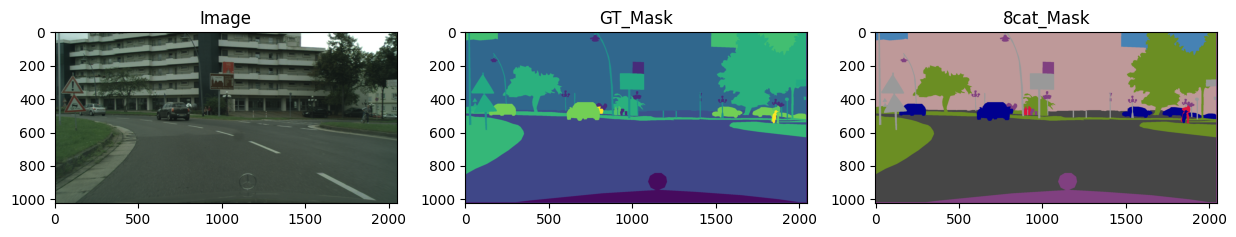

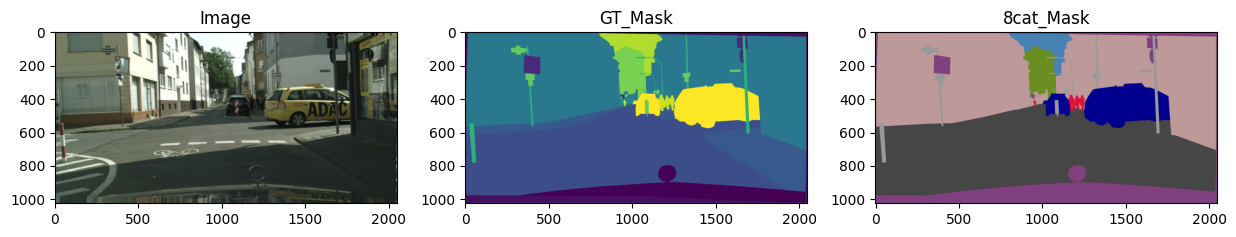

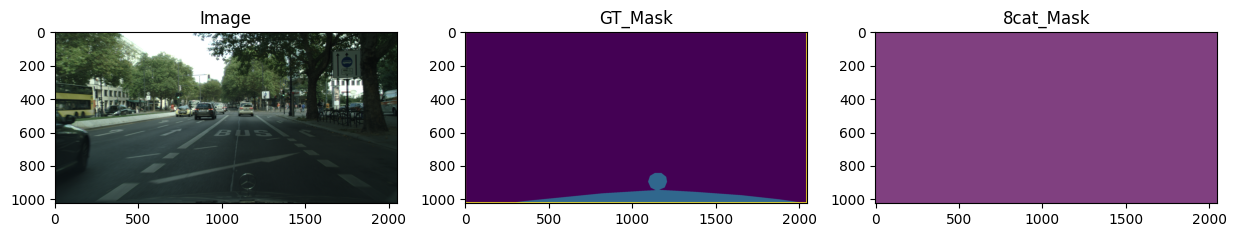

In [4]:
splits = ['train', 'val', 'test']
MASK_MASK = 'labelIds'
split_dic = {}
data_root = 'Datas/reorganized_cityscape_data'
for split in splits:
    print(f'In {split}:\n' )
    images_dir = Path(data_root) / split / 'images'
    masks_dir = Path(data_root) / split / 'masks'
    # image_dir = 'Datas/images'
    # mask_dir = 'Datas/masks'
    image_list = os.listdir(images_dir)
    mask_list = [file for file in os.listdir(masks_dir) if MASK_MASK in file]
    image_list.sort()
    mask_list.sort()
    # create label_dic
    label_dic = {}
    for i,k in enumerate(image_list):
        label_dic[k] = mask_list[i]

    split_dic[split]={
        'image_list' : image_list,
        'label_dic' : label_dic
    }

    print(f'Number of images: {len(image_list)}\nNumber of masks: {len(mask_list)}')
    get_image_n_mask(0, images_dir, masks_dir, image_list, label_dic, display_img_n_info=True)
    






In [5]:
def display_mask_chart(mask):
    """
    Display the mask as a color-coded chart with legend
    """
    colored_mask = get_mask_as_chart(mask)
    
    # Category names for legend
    category_names = ['void', 'flat', 'construction', 'object', 
                     'nature', 'sky', 'human', 'vehicle']
    
    # Colors for legend (same as above)
    colors = [
        [128, 64, 128],    # void
        [70, 70, 70],      # flat  
        [190, 153, 153],   # construction
        [153, 153, 153],   # object
        [107, 142, 35],    # nature
        [70, 130, 180],    # sky
        [220, 20, 60],     # human
        [0, 0, 142]        # vehicle
    ]
    
    # Create plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Display the colored mask
    ax1.imshow(colored_mask)
    ax1.set_title('Semantic Segmentation Mask')
    ax1.axis('off')
    
    # Create legend
    for i, (name, color) in enumerate(zip(category_names, colors)):
        color = np.array(color) / 255.0  # Normalize to [0,1] for matplotlib
        ax2.plot([0], [0], color=color, linewidth=10, label=name)
    
    ax2.legend(loc='center', fontsize=12)
    ax2.axis('off')
    ax2.set_title('Categories Legend')
    
    plt.tight_layout()
    plt.show()
    
    return colored_mask

On sait déja que l'on a a jusqu'a 34 valeur unique correspondant à des sous-catégories mais on ne veux travailler qu'avec les huits catégories qui les contiennent

# II. Data generator

In [6]:
import numpy as np
import keras
import numpy as np
import keras

class CityscapeDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, image_list, mask_dic, image_dir, masks_dir, batch_size=32, dim=(256,256), n_channels=3,
                 n_classes=8, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.mask_dic = mask_dic
        self.image_dir = image_dir
        self.mask_dir = masks_dir
        self.image_list = image_list
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_list) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        image_list_temp = [self.image_list[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(image_list_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, image_list_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.dim[0]*self.dim[1], self.n_classes), dtype=int)

        # Generate data
        for i, ID in enumerate(image_list_temp):
            temp_x,temp_y = get_image_n_mask(i, self.image_dir, self.mask_dir, image_list_temp, self.mask_dic,
                                             img_height= self.dim[0],img_width = self.dim[1],flatten_mask=True)
            # Store sample
            X[i,] = temp_x

            # Store class
            y[i] = temp_y
        return X, y

In [7]:
def get_split_generator(params={},splits=['train','val']):
    generators_dic = {}
    for split in splits:   
        split_images_dir = Path(data_root) / split / 'images'
        split_masks_dir = Path(data_root) / split / 'masks'
        split_data_dic = split_dic[split]
        image_list = split_data_dic['image_list'] 
        mask_dic = split_data_dic['label_dic']
        split_batch_generator = CityscapeDataGenerator(image_list,mask_dic,split_images_dir,split_masks_dir,**params)
        generators_dic[split]=split_batch_generator
    return generators_dic

generator_dic = get_split_generator()

# III. Entrainement

In [8]:
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
# import random
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.python.keras import backend as K
# from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D
# # from tensorflow.python.keras.optimizers import Adadelta, Nadam
# from tensorflow.python.keras.models import Model, load_model
# from tensorflow.python.keras.utils import multi_gpu_model, plot_model
# from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# from keras.preprocessing import image
# import tensorflow as tf
# from tensorflow.python.keras.losses import binary_crossentropy
# # from multiclassunet import Unet
# import tqdm
# import cv2
# from tensorflow.python.keras.utils import Sequence
# from tensorflow.python.keras.callbacks import Callback
# # from dilatednet import DilatedNet

## Model

In [9]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout, Reshape, Permute
# from tensorflow.python.keras.optimizers import Adadelta, Nadam
from keras.models import Model, load_model
# from tensorflow.python.keras.utils import multi_gpu_model, plot_model
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing import image
import tensorflow as tf
from keras.losses import binary_crossentropy

# [ 148343025 1162958786  215752525]
# [0.687561014639342, 5.390244151256168, 1.0]
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def Unet(img_height, img_width, nclasses=3, filters=64):
# down
    input_layer = Input(shape=(img_height, img_width, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
# output
    output_layer = Conv2D(filters=nclasses, kernel_size=(1, 1))(deconv9)
    output_layer = BatchNormalization()(output_layer)
    output_layer = Reshape((img_height*img_width, nclasses), input_shape=(img_height, img_width, nclasses))(output_layer)
    output_layer = Activation('softmax')(output_layer)
    
    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model    

## Métriques

In [10]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def total_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + (3*dice_loss(y_true, y_pred))
    return loss


## Mlflow

In [11]:
import mlflow
import subprocess

def start_local_experiment( host='127.0.0.1',
                            port='8080',
                            uri=r'/mlruns',
                            experiment_name="cityscape"
                            ):
    command = f'''mlflow server --host {host}  --port {port} \n
                mlflow ui --backend-store-uri {uri}'''
    print(command)

    result = subprocess.Popen(command, shell=True)

    mlflow.set_tracking_uri(uri=f"http://{host}:{port}")

    mlflow.set_experiment(experiment_name)

start_local_experiment()


mlflow server --host 127.0.0.1  --port 8080 

                mlflow ui --backend-store-uri /mlruns


INFO:     Uvicorn running on http://127.0.0.1:8080 (Press CTRL+C to quit)
INFO:     Started parent process [1471]
INFO:     Started server process [1473]
INFO:     Waiting for application startup.
INFO:     Started server process [1475]
INFO:     Waiting for application startup.
INFO:     Started server process [1474]
INFO:     Application startup complete.
INFO:     Started server process [1476]
INFO:     Application startup complete.
INFO:     Waiting for application startup.
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Application startup complete.


INFO:     127.0.0.1:53078 - "GET /api/2.0/mlflow/experiments/get-by-name?experiment_name=cityscape HTTP/1.1" 200 OK


In [ ]:
import time


def cityscape_experiment(model_func = Unet,
                         model_params = {
                             'img_height' : 256,
                             'img_width'  : 256,
                             'nclasses'   : 8
                         },
                         gen_params = {'batch_size':4},
                        metrics = [
                                    # dice_coeff,
                                    'accuracy'],
                        train_step_per_epoch = 93, #sample/batch_size
                        val_step_per_epoch = 16,
                        num_epochs = 8,
                        training_description = 'cityscape segmentation experiments',
                        model_name = 'Unet',
                        
                        **kwargs

                        ):
    start_time = time.time()

    model = model_func(**model_params)

    generator_dic = get_split_generator(params=gen_params)
    train_generator = generator_dic['train']

    if train_step_per_epoch is None:
        train_step_per_epoch = int(len(train_generator.image_list)/train_generator.batch_size)
    
    val_generator= generator_dic['val']

    if val_step_per_epoch is None:
        val_step_per_epoch = int(len(val_generator.image_list)/val_generator.batch_size)

    optimizer=kwargs.get('optimizer','adam')
    loss = kwargs.get('loss','categorical_crossentropy')
    monitor=kwargs.get('monitor','val_loss')
    model.compile(optimizer=optimizer, 
                  loss=loss, metrics=metrics)
    
    
    mlflow.tensorflow.autolog()
    callbacks = []
    if kwargs.get('use_tensorboard',False):
        tb = TensorBoard(log_dir='logs', write_graph=True)
        callbacks.append(tb)
    if kwargs.get('use_checkpoint',False):
        mc = ModelCheckpoint(
                            mode='max', 
                            filepath='models-dr/pdilated.weights.h5', 
                            monitor=monitor, 
                            save_best_only='True', 
                            save_weights_only='True', 
                            verbose=1)
        callbacks.append(mc)
    es = EarlyStopping(
                        monitor=monitor,
                        mode='min',
                    #    mode='max', 
                    #    monitor='acc', 
                        patience=1, 
                        verbose=1)
    callbacks.append(es)
    # vis = visualize()


    mlflow.tensorflow.autolog()
    history =  model.fit( #fit_generator deprecated
                train_generator,
                steps_per_epoch=train_step_per_epoch,
                epochs=num_epochs,
                verbose=1,
                validation_data=val_generator,
                validation_steps=val_step_per_epoch,
                # use_multiprocessing=True,
                # workers=16,
                callbacks=callbacks,
                # max_queue_size=32,
                )

    process_time = time.time() - start_time

    prediction_test_fig = visualize_model_prediction(model)

    # Start an MLflow run
    with mlflow.start_run() as run:
        mlflow.log_figure(prediction_test_fig, "prediction_test.png")

        signature = None
        # Infer the model signature
        # if sign_model:
        #     signature = infer_signature(X_train, model.predict(X_train), model_params )


        model_info  = mlflow.keras.log_model(
                                    model=model,        
                                    name=model_name,
                                    signature=signature,
                                    input_example=None,
                                    registered_model_name=f"{model_name}",
                                    )

        
        # hash_id = None
        # try:
        #     import hashlib
        #     hash_id = hashlib.sha256(df.to_string().encode()).hexdigest()
        # except:
        #     pass

        # Log other information about the model
        mlflow.log_params({ "Process_Time": process_time,
                           'ModelParams' : model_params,
                            'optimizer':optimizer,
                            'loss':loss,
                            'monitor':monitor,
                            'GenParams' : gen_params,
                            'Metrics' : metrics,
                            'TrainStepPerEpoch' : train_step_per_epoch, #sample/batch_size
                            'ValStepPerEpoch' : val_step_per_epoch,
                            'Epochs' : num_epochs,
                            # 'DataHash': hash_id,
                            # 'dataset_path':df_path,
                            # 'dataset_length':len(df.index),
                            
                            })

        # Set a tag that we can use to remind ourselves what this model was for
        mlflow.set_logged_model_tags(
            model_info.model_id, {"Training Info": training_description,
                                  
                                  }
        )

        # mlflow.keras.load_model(model_info.model_uri)


In [13]:
params={    
    'model_func' : Unet,
    'model_params' : {
        'img_height' : 256,
        'img_width'  : 256,
        'nclasses'   : 8
    },
    'gen_params' : {'batch_size':4},
    'metrics' : [
            # dice_coeff,
            'accuracy'],
    'train_step_per_epoch' : None, #sample/batch_size
    'val_step_per_epoch' : None,
    'num_epochs' : 8,
    'training_description' : 'cityscape segmentation experiments',
    'model_name' : 'Unet',
    }


/home/d0t/miniconda3/envs/tf-wsl/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025/09/30 11:27:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '419607b560f74d94bca1e0d314b41c0a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


INFO:     127.0.0.1:49640 - "POST /api/2.0/mlflow/runs/create HTTP/1.1" 200 OK
INFO:     127.0.0.1:49640 - "POST /api/2.0/mlflow/runs/log-parameter HTTP/1.1" 200 OK
INFO:     127.0.0.1:49640 - "POST /api/2.0/mlflow/runs/log-batch HTTP/1.1" 200 OK
INFO:     127.0.0.1:49640 - "POST /api/2.0/mlflow/runs/log-batch HTTP/1.1" 200 OK


2025/09/30 11:27:34 WARNING mlflow.tensorflow: Unrecognized dataset type <class '__main__.CityscapeDataGenerator'>. Dataset logging skipped.
2025/09/30 11:27:34 WARNING mlflow.tensorflow: Unrecognized dataset type <class '__main__.CityscapeDataGenerator'>. Dataset logging skipped.


INFO:     127.0.0.1:49640 - "POST /api/2.0/mlflow/logged-models HTTP/1.1" 200 OK


/home/d0t/miniconda3/envs/tf-wsl/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


INFO:     127.0.0.1:49640 - "POST /api/2.0/mlflow/runs/log-batch HTTP/1.1" 200 OK


INFO:     127.0.0.1:49640 - "GET /api/2.0/mlflow/runs/get?run_uuid=419607b560f74d94bca1e0d314b41c0a&run_id=419607b560f74d94bca1e0d314b41c0a HTTP/1.1" 200 OK
INFO:     127.0.0.1:49640 - "PUT /api/2.0/mlflow-artifacts/artifacts/372886525690534527/419607b560f74d94bca1e0d314b41c0a/artifacts/model_summary.txt HTTP/1.1" 200 OK
Epoch 1/8


2025-09-30 11:27:46.445647: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-30 11:27:46.747693: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-30 11:27:47.497650: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-30 11:27:48.046200: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-30 11:27:48.067473: E external/local_xla/xla/service

743/743 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.7428 - loss: 1.0119INFO:     127.0.0.1:59210 - "GET /api/2.0/mlflow/runs/get?run_uuid=419607b560f74d94bca1e0d314b41c0a&run_id=419607b560f74d94bca1e0d314b41c0a HTTP/1.1" 200 OK
INFO:     127.0.0.1:59210 - "GET /api/2.0/mlflow/runs/get?run_uuid=419607b560f74d94bca1e0d314b41c0a&run_id=419607b560f74d94bca1e0d314b41c0a HTTP/1.1" 200 OK
INFO:     127.0.0.1:59210 - "POST /api/2.0/mlflow/runs/log-batch HTTP/1.1" 200 OK
INFO:     127.0.0.1:59214 - "GET /api/2.0/mlflow/runs/get?run_uuid=419607b560f74d94bca1e0d314b41c0a&run_id=419607b560f74d94bca1e0d314b41c0a HTTP/1.1" 200 OK


INFO:     127.0.0.1:59214 - "GET /api/2.0/mlflow/runs/get?run_uuid=419607b560f74d94bca1e0d314b41c0a&run_id=419607b560f74d94bca1e0d314b41c0a HTTP/1.1" 200 OK
INFO:     127.0.0.1:59210 - "POST /api/2.0/mlflow/runs/set-tag HTTP/1.1" 200 OK
INFO:     127.0.0.1:59214 - "POST /api/2.0/mlflow/runs/log-batch HTTP/1.1" 200 OK
INFO:     127.0.0.1:59210 - "PUT /api/2.0/mlflow-artifacts/artifacts/372886525690534527/419607b560f74d94bca1e0d314b41c0a/artifacts/checkpoints/latest_checkpoint_metrics.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:59214 - "PUT /api/2.0/mlflow-artifacts/artifacts/372886525690534527/419607b560f74d94bca1e0d314b41c0a/artifacts/checkpoints/latest_checkpoint.h5 HTTP/1.1" 200 OK
743/743 ━━━━━━━━━━━━━━━━━━━━ 356s 432ms/step - accuracy: 0.7429 - loss: 1.0117 - val_accuracy: 0.8336 - val_loss: 0.6266
Epoch 2/8
743/743 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.8538 - loss: 0.5407INFO:     127.0.0.1:48718 - "GET /api/2.0/mlflow/runs/get?run_uuid=419607b560f74d94bca1e0d314b41c0a&ru

INFO:     127.0.0.1:48732 - "GET /api/2.0/mlflow/runs/get?run_uuid=419607b560f74d94bca1e0d314b41c0a&run_id=419607b560f74d94bca1e0d314b41c0a HTTP/1.1" 200 OK
INFO:     127.0.0.1:48718 - "POST /api/2.0/mlflow/runs/set-tag HTTP/1.1" 200 OK
INFO:     127.0.0.1:48732 - "POST /api/2.0/mlflow/runs/log-batch HTTP/1.1" 200 OK
INFO:     127.0.0.1:48718 - "PUT /api/2.0/mlflow-artifacts/artifacts/372886525690534527/419607b560f74d94bca1e0d314b41c0a/artifacts/checkpoints/latest_checkpoint_metrics.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:48718 - "PUT /api/2.0/mlflow-artifacts/artifacts/372886525690534527/419607b560f74d94bca1e0d314b41c0a/artifacts/checkpoints/latest_checkpoint.h5 HTTP/1.1" 200 OK
743/743 ━━━━━━━━━━━━━━━━━━━━ 283s 381ms/step - accuracy: 0.8538 - loss: 0.5406 - val_accuracy: 0.8289 - val_loss: 0.5855
Epoch 3/8
743/743 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8716 - loss: 0.4493INFO:     127.0.0.1:33546 - "GET /api/2.0/mlflow/runs/get?run_uuid=419607b560f74d94bca1e0d314b41c0a&ru

INFO:     127.0.0.1:33562 - "GET /api/2.0/mlflow/runs/get?run_uuid=419607b560f74d94bca1e0d314b41c0a&run_id=419607b560f74d94bca1e0d314b41c0a HTTP/1.1" 200 OK
INFO:     127.0.0.1:33546 - "POST /api/2.0/mlflow/runs/set-tag HTTP/1.1" 200 OK
INFO:     127.0.0.1:33546 - "PUT /api/2.0/mlflow-artifacts/artifacts/372886525690534527/419607b560f74d94bca1e0d314b41c0a/artifacts/checkpoints/latest_checkpoint_metrics.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:33562 - "POST /api/2.0/mlflow/runs/log-batch HTTP/1.1" 200 OK
INFO:     127.0.0.1:33546 - "PUT /api/2.0/mlflow-artifacts/artifacts/372886525690534527/419607b560f74d94bca1e0d314b41c0a/artifacts/checkpoints/latest_checkpoint.h5 HTTP/1.1" 200 OK
743/743 ━━━━━━━━━━━━━━━━━━━━ 307s 412ms/step - accuracy: 0.8716 - loss: 0.4493 - val_accuracy: 0.8614 - val_loss: 0.4700
Epoch 4/8
743/743 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.8824 - loss: 0.3986INFO:     127.0.0.1:45308 - "GET /api/2.0/mlflow/runs/get?run_uuid=419607b560f74d94bca1e0d314b41c0a&ru

2025/09/30 11:47:12 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2025/09/30 11:47:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


INFO:     127.0.0.1:45314 - "POST /api/2.0/mlflow/runs/log-batch HTTP/1.1" 200 OK
INFO:     127.0.0.1:45308 - "GET /api/2.0/mlflow/logged-models/m-3717a4bd243048649ebd42e5a47595b0 HTTP/1.1" 200 OK
INFO:     127.0.0.1:45308 - "POST /api/2.0/mlflow/runs/outputs HTTP/1.1" 200 OK
INFO:     127.0.0.1:45308 - "GET /api/2.0/mlflow/runs/get?run_uuid=419607b560f74d94bca1e0d314b41c0a&run_id=419607b560f74d94bca1e0d314b41c0a HTTP/1.1" 200 OK
INFO:     127.0.0.1:45308 - "GET /api/2.0/mlflow/metrics/get-history?run_uuid=419607b560f74d94bca1e0d314b41c0a&metric_key=accuracy&run_id=419607b560f74d94bca1e0d314b41c0a&max_results=25000 HTTP/1.1" 200 OK
INFO:     127.0.0.1:45308 - "GET /api/2.0/mlflow/metrics/get-history?run_uuid=419607b560f74d94bca1e0d314b41c0a&metric_key=loss&run_id=419607b560f74d94bca1e0d314b41c0a&max_results=25000 HTTP/1.1" 200 OK
INFO:     127.0.0.1:45308 - "GET /api/2.0/mlflow/metrics/get-history?run_uuid=419607b560f74d94bca1e0d314b41c0a&metric_key=validation_accuracy&run_id=419607b56

2025/09/30 11:47:13 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:     127.0.0.1:45308 - "POST /api/2.0/mlflow/runs/log-batch HTTP/1.1" 200 OK


2025/09/30 11:47:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


INFO:     127.0.0.1:50206 - "GET /api/2.0/mlflow/logged-models/m-3717a4bd243048649ebd42e5a47595b0 HTTP/1.1" 200 OK
INFO:     127.0.0.1:50206 - "PUT /api/2.0/mlflow-artifacts/artifacts/372886525690534527/models/m-3717a4bd243048649ebd42e5a47595b0/artifacts/conda.yaml HTTP/1.1" 200 OK
INFO:     127.0.0.1:50206 - "PUT /api/2.0/mlflow-artifacts/artifacts/372886525690534527/models/m-3717a4bd243048649ebd42e5a47595b0/artifacts/python_env.yaml HTTP/1.1" 200 OK
INFO:     127.0.0.1:50206 - "PUT /api/2.0/mlflow-artifacts/artifacts/372886525690534527/models/m-3717a4bd243048649ebd42e5a47595b0/artifacts/MLmodel HTTP/1.1" 200 OK
INFO:     127.0.0.1:50206 - "PUT /api/2.0/mlflow-artifacts/artifacts/372886525690534527/models/m-3717a4bd243048649ebd42e5a47595b0/artifacts/requirements.txt HTTP/1.1" 200 OK
INFO:     127.0.0.1:50206 - "PUT /api/2.0/mlflow-artifacts/artifacts/372886525690534527/models/m-3717a4bd243048649ebd42e5a47595b0/artifacts/data/model.keras HTTP/1.1" 200 OK
INFO:     127.0.0.1:50206 - "PU

2025/09/30 11:48:31 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


INFO:     127.0.0.1:36092 - "GET /api/2.0/mlflow/runs/get?run_uuid=f5a7fc1670c74e3aaf748ebb2f452d2c&run_id=f5a7fc1670c74e3aaf748ebb2f452d2c HTTP/1.1" 200 OK
INFO:     127.0.0.1:56606 - "GET /static-files/static/js/2149.2b521c18.chunk.js HTTP/1.1" 200 OK
INFO:     127.0.0.1:56566 - "GET /static-files/static/js/2633.4202aaab.chunk.js HTTP/1.1" 200 OK
INFO:     127.0.0.1:56610 - "GET /static-files/static/css/5293.5f214259.chunk.css HTTP/1.1" 200 OK
INFO:     127.0.0.1:56596 - "GET /static-files/static/js/2586.11dd4abc.chunk.js HTTP/1.1" 200 OK
INFO:     127.0.0.1:56608 - "GET /static-files/static/js/701.4cd15ac7.chunk.js HTTP/1.1" 200 OK
INFO:     127.0.0.1:56582 - "GET /static-files/static/js/47.fbc06a47.chunk.js HTTP/1.1" 200 OK
INFO:     127.0.0.1:56610 - "GET /static-files/static/js/5293.35c80ee2.chunk.js HTTP/1.1" 200 OK
INFO:     127.0.0.1:56566 - "GET /ajax-api/2.0/mlflow/model-versions/search?filter=tags.%60mlflow.prompt.is_prompt%60+%3D+%27true%27+AND+tags.%60mlflow.prompt.run_id

2025/09/30 11:48:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


INFO:     127.0.0.1:47758 - "GET /api/2.0/mlflow/logged-models/m-1818acf50be642c2835c0002e51da2c8 HTTP/1.1" 200 OK
INFO:     127.0.0.1:47758 - "PUT /api/2.0/mlflow-artifacts/artifacts/372886525690534527/models/m-1818acf50be642c2835c0002e51da2c8/artifacts/conda.yaml HTTP/1.1" 200 OK
INFO:     127.0.0.1:47758 - "PUT /api/2.0/mlflow-artifacts/artifacts/372886525690534527/models/m-1818acf50be642c2835c0002e51da2c8/artifacts/python_env.yaml HTTP/1.1" 200 OK
INFO:     127.0.0.1:47758 - "PUT /api/2.0/mlflow-artifacts/artifacts/372886525690534527/models/m-1818acf50be642c2835c0002e51da2c8/artifacts/MLmodel HTTP/1.1" 200 OK
INFO:     127.0.0.1:47752 - "GET /get-artifact?path=model_summary.txt&run_uuid=419607b560f74d94bca1e0d314b41c0a HTTP/1.1" 200 OK
INFO:     127.0.0.1:47758 - "PUT /api/2.0/mlflow-artifacts/artifacts/372886525690534527/models/m-1818acf50be642c2835c0002e51da2c8/artifacts/requirements.txt HTTP/1.1" 200 OK
INFO:     127.0.0.1:47752 - "GET /ajax-api/2.0/mlflow/artifacts/list?run_uui

Registered model 'Unet' already exists. Creating a new version of this model...
2025/09/30 11:49:25 ERROR mlflow.webhooks.delivery: Failed to deliver webhook for event model_version.created: FileStore does not support list_webhooks_by_event
Traceback (most recent call last):
  File "/home/d0t/miniconda3/envs/tf-wsl/lib/python3.12/site-packages/mlflow/webhooks/delivery.py", line 304, in deliver_webhook
    _deliver_webhook_impl(event=event, payload=payload, store=store)
  File "/home/d0t/miniconda3/envs/tf-wsl/lib/python3.12/site-packages/mlflow/webhooks/delivery.py", line 285, in _deliver_webhook_impl
    webhooks = _get_cached_webhooks_by_event(store, event, ttl_seconds)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/d0t/miniconda3/envs/tf-wsl/lib/python3.12/site-packages/mlflow/webhooks/delivery.py", line 249, in _get_cached_webhooks_by_event
    page = store.list_webhooks_by_event(event, max_results=100, page_token=page_token)
           ^^^^^^

INFO:     127.0.0.1:47758 - "POST /api/2.0/mlflow/model-versions/create HTTP/1.1" 200 OK
INFO:     127.0.0.1:47758 - "GET /api/2.0/mlflow/logged-models/m-1818acf50be642c2835c0002e51da2c8 HTTP/1.1" 200 OK
INFO:     127.0.0.1:47758 - "GET /api/2.0/mlflow/logged-models/m-1818acf50be642c2835c0002e51da2c8 HTTP/1.1" 200 OK
INFO:     127.0.0.1:47758 - "PATCH /api/2.0/mlflow/logged-models/m-1818acf50be642c2835c0002e51da2c8/tags HTTP/1.1" 200 OK
INFO:     127.0.0.1:47758 - "GET /api/2.0/mlflow/runs/get?run_uuid=f5a7fc1670c74e3aaf748ebb2f452d2c&run_id=f5a7fc1670c74e3aaf748ebb2f452d2c HTTP/1.1" 200 OK
INFO:     127.0.0.1:47758 - "PUT /api/2.0/mlflow-artifacts/artifacts/372886525690534527/f5a7fc1670c74e3aaf748ebb2f452d2c/artifacts/prediction_test.png HTTP/1.1" 200 OK
INFO:     127.0.0.1:47758 - "POST /api/2.0/mlflow/runs/log-batch HTTP/1.1" 200 OK
INFO:     127.0.0.1:47758 - "GET /api/2.0/mlflow/logged-models/m-1818acf50be642c2835c0002e51da2c8 HTTP/1.1" 200 OK
INFO:     127.0.0.1:47758 - "PATCH /a

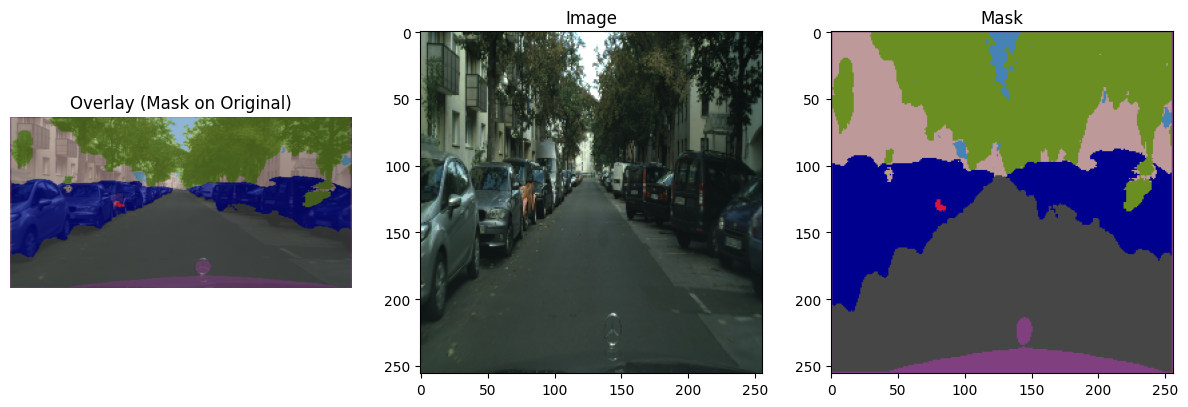

INFO:     127.0.0.1:38486 - "GET /ajax-api/2.0/mlflow/artifacts/list?run_uuid=419607b560f74d94bca1e0d314b41c0a HTTP/1.1" 200 OK
INFO:     127.0.0.1:38486 - "GET /get-artifact?path=model_summary.txt&run_uuid=419607b560f74d94bca1e0d314b41c0a HTTP/1.1" 304 Not Modified
INFO:     127.0.0.1:52072 - "GET /ajax-api/2.0/mlflow/artifacts/list?run_uuid=419607b560f74d94bca1e0d314b41c0a&path=tensorboard_logs HTTP/1.1" 200 OK
INFO:     127.0.0.1:52072 - "GET /ajax-api/2.0/mlflow/artifacts/list?run_uuid=419607b560f74d94bca1e0d314b41c0a&path=checkpoints HTTP/1.1" 200 OK
INFO:     127.0.0.1:40982 - "GET /ajax-api/2.0/mlflow/model-versions/search?filter=run_id%3D%27419607b560f74d94bca1e0d314b41c0a%27 HTTP/1.1" 200 OK
INFO:     127.0.0.1:50732 - "GET /ajax-api/2.0/mlflow/model-versions/search?filter=run_id%3D%27419607b560f74d94bca1e0d314b41c0a%27 HTTP/1.1" 200 OK
INFO:     127.0.0.1:33380 - "GET /ajax-api/2.0/mlflow/model-versions/search?filter=run_id%3D%27419607b560f74d94bca1e0d314b41c0a%27 HTTP/1.1" 2

In [16]:
cityscape_experiment(**params)

## Visualisation

In [14]:
BEST_MODEL_PATH = 'mlartifacts/372886525690534527/models/m-a2e79d2083074d409c5d7e5e96958989/artifacts/data/model.keras'

model = keras.saving.load_model(BEST_MODEL_PATH, custom_objects=None, compile=False, safe_mode=True)

I0000 00:00:1759224414.506745    1313 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:0a:00.0, compute capability: 8.6


I0000 00:00:1759224418.415954    1677 service.cc:152] XLA service 0x7f2eb8001fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759224418.415994    1677 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-09-30 11:26:58.438883: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759224418.635777    1677 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-09-30 11:27:00.130953: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-09-30 11:27:00.432603: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, p

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


I0000 00:00:1759224424.255520    1677 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


mask shape is (256, 256, 8)


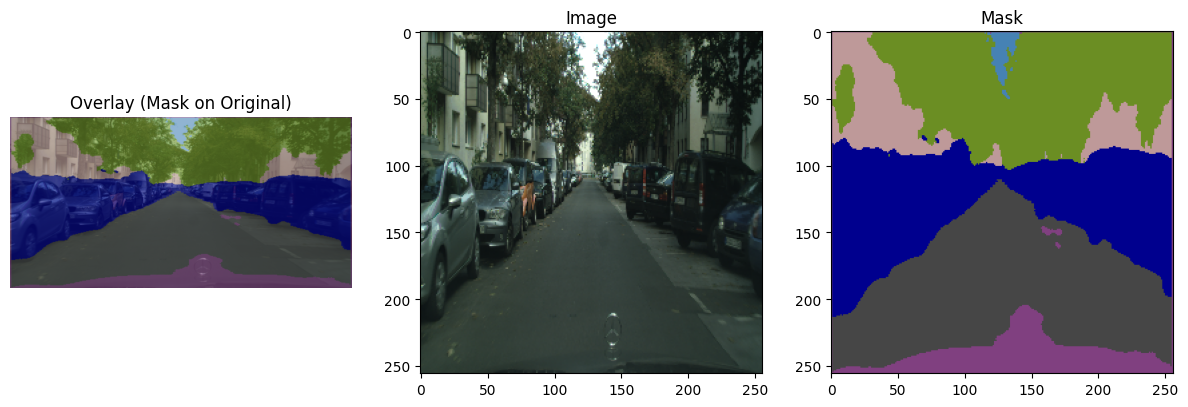

In [15]:
IMAGE_TEST_PATH = 'Datas/reorganized_cityscape_data/test/images/berlin_000005_000019_leftImg8bit.png'
import tensorflow as tf

def visualize_model_prediction(model,
                               image_test_path = IMAGE_TEST_PATH,
                               training_target_size = (256,256)
                               ):
    image_raw = image.load_img(image_test_path)
    image_resized = image.load_img(image_test_path,target_size=training_target_size)

    array_image_raw = image.img_to_array(image_raw)/255.
    array_image_resized = image.img_to_array(image_resized)/255.

    # Add batch dimension to make it (1, 256, 256, 3)
    input_batch = np.expand_dims(array_image_resized, axis=0)

    mask = model.predict(input_batch)
    mask = mask[0]  
    # Reshape the mask from (65536, 8) to (256, 256, 8)
    mask = mask.reshape(training_target_size[0], training_target_size[1], 8)
    print(f'mask shape is {mask.shape}')
    mask_array = get_mask_as_chart(mask)

    fig = plt.figure(figsize=(15, 15))
    # ax = fig.add_subplot(1, 3, 1)
    # ax.set_title('Image')
    # ax.imshow(array_image_raw)

    ax1 = fig.add_subplot(1, 3, 2)
    ax1.set_title('Image')
    ax1.imshow(array_image_resized)

    ax2 = fig.add_subplot(1, 3, 3)
    ax2.set_title('Mask')
    ax2.imshow(mask_array)

    # Resize mask to raw image dimensions for overlay
    raw_height, raw_width = array_image_raw.shape[0], array_image_raw.shape[1]
    mask_resized = tf.image.resize(mask_array, [raw_height, raw_width], 
                              method=tf.image.ResizeMethod.NEAREST_NEIGHBOR).numpy().astype(np.uint8)
    
    # Create overlay (you can adjust alpha for transparency)
    alpha = 0.6
    overlay = (array_image_raw * (1 - alpha) + mask_resized/255.0 * alpha)

    ax3 = fig.add_subplot(1, 3, 1)
    ax3.set_title('Overlay (Mask on Original)')
    ax3.imshow(overlay)
    ax3.axis('off')

    return fig

fig = visualize_model_prediction(model)